In [47]:
# importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import itertools  
import pickle

import keras
from keras.applications import VGG19
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input,Conv2D,MaxPooling2D, Flatten,Dense
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn import svm

In [21]:
def plot_ROC(y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    #https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print(roc_auc)
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot of a ROC curve for a specific class
    for i in range(3):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)'.format(roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

    

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='confusion matrix',
                         cmap=plt.cm.Reds):
    # this funcation print & plots confusion matrix
    # normalize can be applied by  normalize=True,
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks= np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm= cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print(" confusion matrix, without normalized")
    print(cm)

    thresh=cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
    '''input to confusion_matrix must be a list of predictions, not OHEs (one hot encodings). Call argmax on your y_test and y_pred, and you should get what you expect.'''
     

In [51]:
pickle_in = open("X_train.pickle","rb")
X_train = pickle.load(pickle_in)

pickle_in = open("y_train.pickle","rb")
y_train = pickle.load(pickle_in)
pickle_in = open("X_test.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in = open("y_test.pickle","rb")
y_test = pickle.load(pickle_in)


model_vgg19_conv= VGG19(weights='imagenet', include_top=False)
#model_vgg16_conv.summary()

#Create your own input format
keras_input = Input(shape=(300,200,3), name = 'image_input')


x=model_vgg19_conv(keras_input)
#Add the fully-connected layers 
x = Flatten(name='flatten')(x)
x=Dense(4096, activation= 'relu')(x)
vgg19_model = Model(inputs=keras_input, outputs=x)
vgg19_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
X_train = vgg19_model.predict(X_train,verbose=1)
X_test = vgg19_model.predict(X_test,verbose=1)

40/40 [==============================] - 37s 917ms/step


accuracy of :  0.65
0.7550133689839572
{0: 0.6363636363636364}
{0: 0.6363636363636364, 1: 0.7708333333333333}
{0: 0.6363636363636364, 1: 0.7708333333333333, 2: 0.857843137254902}


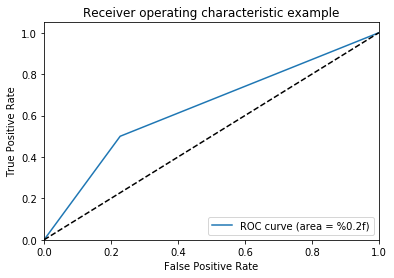

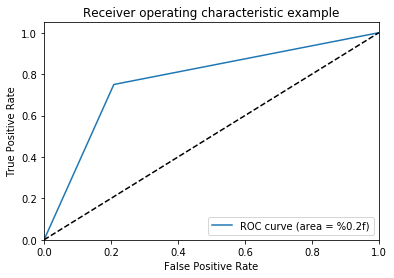

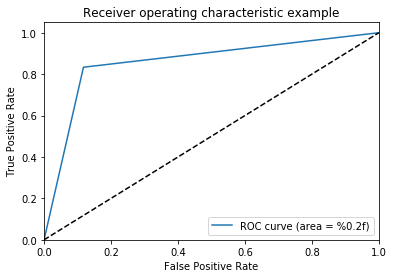

In [42]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear',probability=True) # Linear Kernel


#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print("accuracy of : ",acc)

y_t =keras.utils.to_categorical(y_test, num_classes=3)#one hot encoding to plot the Roc Carve and calculate roc auc
y_p =keras.utils.to_categorical(y_pred, num_classes=3)#one hot encoding
auc_value=sklearn.metrics.roc_auc_score(y_t, y_p)
print(auc_value)

plot_ROC(y_t,y_p)

In [56]:
#try with cross-validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf ,X=X_train , y=y_train , cv = 10)
print (accuracies)
print(accuracies.mean()) #relivent evalution of the model 

[0.66666667 0.61111111 0.76470588 0.47058824 0.73333333 0.6
 0.6        0.4        0.53333333 0.4       ]
0.5779738562091503


confusion matrix of :  [[ 9  5  4]
 [ 4 12  0]
 [ 1  0  5]]
 confusion matrix, without normalized
[[ 9  5  4]
 [ 4 12  0]
 [ 1  0  5]]


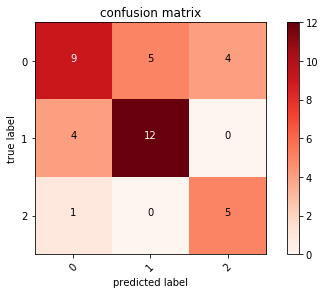

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_t.argmax(axis=1), y_p.argmax(axis=1))
print("confusion matrix of : ",cm)

from sklearn.utils.multiclass import unique_labels
classes = unique_labels(y_t, y_p)
plot_confusion_matrix(cm,classes)

accuracy of :  0.625
AUC : 0.7744540998217468
{0: 0.6818181818181818}
{0: 0.6818181818181818, 1: 0.7395833333333334}
{0: 0.6818181818181818, 1: 0.7395833333333334, 2: 0.9019607843137255}


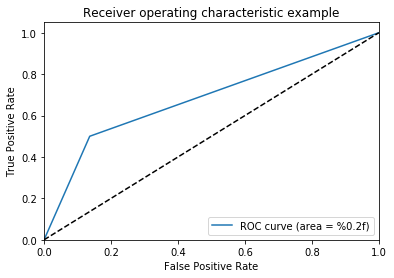

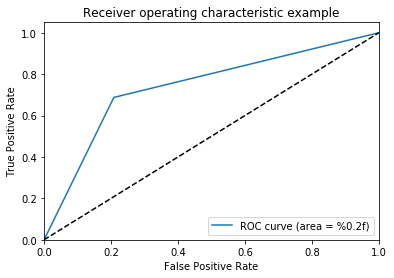

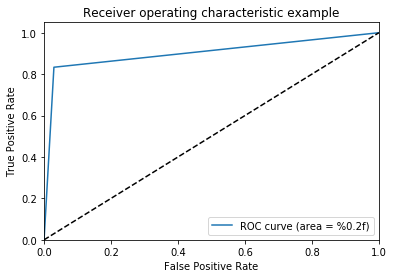

In [53]:
from sklearn.multiclass import OneVsRestClassifier
#Create a svm Classifier
clf2 = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True)) # Linear Kernel
y_testOHL=keras.utils.to_categorical(y_test)

#Train the model using the training sets
clf2.fit(X_train, keras.utils.to_categorical(y_train))

#Predict the response for test dataset
y_predOVR = clf2.predict(X_test)


import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_testOHL, y_predOVR)
print("accuracy of : ",acc)

auc_value=sklearn.metrics.roc_auc_score(y_testOHL, y_predOVR)

print('AUC :',auc_value)

plot_ROC(y_testOHL,y_predOVR)

In [54]:
#try with cross-validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf2 ,X=X_train , y=y_train , cv = 10)
print (accuracies)
print(accuracies.mean()) #relivent evalution of the model 

[0.61111111 0.55555556 0.70588235 0.47058824 0.73333333 0.4
 0.66666667 0.4        0.6        0.4       ]
0.5543137254901961
